In [0]:
import numpy as np
from pathlib import Path
import csv, re, os 
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import math

# Pre-Processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# Keras
from keras.models import Sequential, Model
from keras.utils.np_utils import to_categorical 
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle


from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

from sklearn.preprocessing import OneHotEncoder 

from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
import keras 
from keras import optimizers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
cd /gdrive

/gdrive


In [0]:
def Load_Data():
    # Get Input and Target Data
    input_data = np.ones([1, 60])
    target_data_binary_PHQ = [0]
    target_data_score_PHQ = [0]
    shape=[0]
    
    i = 1
    target_data_csv = Path('/gdrive/My Drive/Zeineb/full_dataset.csv')
    with open(target_data_csv, 'r') as csvFile:
        reader = csv.reader(csvFile)
        for row in reader:
            try:
                participant_ID = str(re.split('\t', row[0])[0])
                binary_PHQ8 = int(re.split('\t', row[1])[0])
                score_PHQ8 = int(re.split('\t', row[2])[0])
                print(" ## \n Participant ID is:{}, with Binary PHQ:{} , and Score PHQ:{} : ", participant_ID, binary_PHQ8, score_PHQ8)
                
                csv_file_path = '/gdrive/My Drive/Zeineb/'+participant_ID+'_P/split/Participant/'   
                if os.path.exists(csv_file_path):
                    input_directory = Path(csv_file_path)
                    for my_csv_filename in input_directory.glob("*_AUDIO_*.csv"):  
                        # Extract the .csv filename   
                        my_csv_filename = my_csv_filename.stem
                        print("## \n Retrieving coef matrix from file: ", my_csv_filename)

                        io = pd.read_csv(csv_file_path+my_csv_filename+'.csv', sep=",", usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60))

                        # Get the Matrix
                        i = i+1
                        io = np.array(io, dtype=np.float64)
                        
                        shape=np.append(shape,io.shape[0])
                        print("{{{{{{{}}}}}}}",io.shape)
                        print("###################################################",io.shape[0])
                        input_data = np.append(input_data, io, axis=0) 
                        
                        for i in range(io.shape[0]):
                            target_data_binary_PHQ.append(binary_PHQ8)
                            target_data_score_PHQ.append(score_PHQ8)
                            
            except ValueError:
                print("Skipping the following line: ", row[0])
    csvFile.close()            
                
    print("the size of my list-input-matrix: ", i)
    
    
    return input_data, target_data_binary_PHQ, target_data_score_PHQ, shape

# Loading data
input_data, target_data_binary_PHQ, target_data_score_PHQ ,shape_sequences= Load_Data()

Skipping the following line:  Participant_ID
 ## 
 Participant ID is:{}, with Binary PHQ:{} , and Score PHQ:{} :  303 0 0
## 
 Retrieving coef matrix from file:  303_AUDIO_43
{{{{{{{}}}}}}} (528, 60)
################################################### 528
## 
 Retrieving coef matrix from file:  303_AUDIO_42
{{{{{{{}}}}}}} (303, 60)
################################################### 303
## 
 Retrieving coef matrix from file:  303_AUDIO_90
{{{{{{{}}}}}}} (84, 60)
################################################### 84
## 
 Retrieving coef matrix from file:  303_AUDIO_26
{{{{{{{}}}}}}} (725, 60)
################################################### 725
## 
 Retrieving coef matrix from file:  303_AUDIO_14
{{{{{{{}}}}}}} (736, 60)
################################################### 736
## 
 Retrieving coef matrix from file:  303_AUDIO_0
{{{{{{{}}}}}}} (113, 60)
################################################### 113
## 
 Retrieving coef matrix from file:  303_AUDIO_82
{{{{{{{}}}}}}} (501, 60)

In [0]:
shape = np.delete(shape_sequences, 0, 0)

target_data_binary_PHQ=pd.DataFrame(target_data_binary_PHQ)
print(target_data_binary_PHQ[0].value_counts())


0    540575
1    485291
Name: 0, dtype: int64


In [0]:
#data balancing
target=np.asarray(target_data_binary_PHQ, dtype=float)
I= np.argwhere(target == 0).flatten() # INDICES OF TARGET VVHERE IT IS NULL 
y= np.random.choice(I,55248)
X = np.delete(input_data, [y], axis=0)
Y = np.delete(target, [y], axis=0)
print(X.shape)
print(Y.shape)


(999189, 60)
(999189, 1)


In [0]:
# Splitting into Training and Testing datasets
input_data = np.asarray(input_data, dtype=np.float64)
target = np.asarray(target_data_binary_PHQ, dtype=float)
x_train, x_test, y_train, y_test = train_test_split(input_data, target, test_size = 0.2 , random_state = 40)

# Normalizing Training data
#print(x_train)
x_train -= np.mean(x_train, axis=0)
#print("####")
#print(x_train)
x_train /= np.std(x_train, axis=0)
#print("####")
#print(x_train)

# Normalizing Testing data
#print(x_test)
x_test -= np.mean(x_test, axis=0)
#print("####")
#print(x_test)
x_test /= np.std(x_test, axis=0)
#print("####")
#print(x_test)


NameError: ignored

In [0]:
NCOMPONENTS = 30
from sklearn.decomposition import PCA

pca = PCA(n_components=NCOMPONENTS)
X_pca_train = pca.fit_transform(x_train)
X_pca_test = pca.transform(x_test)
pca_std = np.std(X_pca_train)

print(x_train.shape)
print(X_pca_train.shape)

NameError: ignored

In [0]:
data=pd.DataFrame(x_train)
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05,8.206920e+05
mean,1.845965e-15,-8.477375e-16,9.525654e-16,6.264891e-15,-1.777714e-14,2.586850e-14,-2.788039e-15,1.146579e-15,-1.041258e-15,7.201282e-15,9.846833e-16,1.208807e-14,2.226583e-16,-6.088135e-15,7.615429e-15,7.646952e-15,-2.235958e-15,-3.487667e-15,-2.006703e-13,-9.581560e-16,-1.783755e-16,-5.608773e-16,-9.360149e-17,2.503252e-16,-3.910600e-16,-3.211873e-17,-5.653968e-17,1.467321e-16,-5.709987e-18,-9.793948e-17,-1.358492e-16,2.012624e-17,-1.855938e-17,5.378797e-17,-1.167527e-16,-1.264899e-17,2.447901e-16,1.215616e-16,2.878283e-16,2.317047e-16,-1.784388e-16,-8.905890e-17,-7.260080e-18,-1.296054e-16,8.192435e-17,1.025411e-16,-1.367710e-17,-2.070239e-17,-7.349499e-18,-4.433191e-17,-1.225321e-16,-3.114661e-18,-5.571840e-17,8.821638e-17,8.803720e-17,8.027409e-17,5.504214e-17,-6.876794e-17,2.556132e-16,1.628383e-13
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.930224e+00,-4.516596e+00,-4.573498e+00,-5.242380e+00,-4.441745e+00,-5.037032e+00,-5.127530e+00,-5.222483e+00,-5.376263e+00,-5.182501e+00,-5.476724e+00,-5.846068e+00,-5.970266e+00,-5.201112e+00,-6.457215e+00,-5.998066e+00,-5.894495e+00,-6.887473e+00,-4.798810e+00,-5.334682e+00,-6.284140e+00,-6.288699e+00,-7.337051e+00,-6.975234e+00,-7.076792e+00,-6.493342e+00,-6.419204e+00,-5.570696e+00,-6.127485e+00,-6.512004e+00,-6.627678e+00,-7.084473e+00,-6.687602e+00,-7.385442e+00,-7.300520e+00,-6.723641e+00,-7.941799e+00,-7.200844e+00,-5.194286e+00,-3.748178e+01,-6.779498e+00,-6.770724e+00,-6.751513e+00,-6.840133e+00,-6.801607e+00,-7.070333e+00,-7.127646e+00,-5.848709e+00,-6.773547e+00,-6.769006e+00,-6.678540e+00,-6.394505e+00,-6.730753e+00,-6.319629e+00,-7.012035e+00,-7.001719e+00,-8.339689e+00,-7.786837e+00,-8.439047e+00,-9.903127e+00
25%,-7.005610e-01,-6.375765e-01,-6.360311e-01,-5.726776e-01,-6.291921e-01,-6.400702e-01,-6.276183e-01,-6.287482e-01,-6.209399e-01,-6.274399e-01,-6.235764e-01,-6.230014e-01,-6.352998e-01,-6.237214e-01,-6.374356e-01,-6.456739e-01,-6.510800e-01,-6.533641e-01,-5.826370e-01,-4.253498e-01,-3.674455e-01,-5.042078e-01,-5.437810e-01,-5.356799e-01,-5.325871e-01,-5.843003e-01,-5.759732e-01,-5.924043e-01,-5.863470e-01,-6.050052e-01,-6.022510e-01,-6.081931e-01,-6.095401e-01,-6.099662e-01,-6.148150e-01,-6.172718e-01,-6.207658e-01,-6.228405e-01,-4.219923e-01,-4.316852e-01,-3.988392e-01,-5.063434e-01,-5.44

In [0]:
X_train = np.expand_dims(x_train, -1)
X_test = np.expand_dims(x_test, -1)

X_train.shape

(820692, 60, 1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
inv_pca = pca.inverse_transform(X_pca_train)
inv_sc = scaler.inverse_transform(inv_pca)

MODEL


In [0]:
epochs = 90
batch_size = 100

verbose = 1
num_classes = 2

In [0]:
y_train.shape

(820692, 1)

In [0]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1)) # contient des binaire / 
y_test = ohe.transform(y_test.reshape(-1,1))
print(y_train)

  (0, 1)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 0)	1.0
  (7, 1)	1.0
  (8, 1)	1.0
  (9, 1)	1.0
  (10, 0)	1.0
  (11, 1)	1.0
  (12, 0)	1.0
  (13, 1)	1.0
  (14, 1)	1.0
  (15, 0)	1.0
  (16, 0)	1.0
  (17, 0)	1.0
  (18, 1)	1.0
  (19, 1)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 1)	1.0
  (24, 0)	1.0
  :	:
  (820667, 0)	1.0
  (820668, 0)	1.0
  (820669, 1)	1.0
  (820670, 0)	1.0
  (820671, 1)	1.0
  (820672, 1)	1.0
  (820673, 1)	1.0
  (820674, 1)	1.0
  (820675, 1)	1.0
  (820676, 1)	1.0
  (820677, 0)	1.0
  (820678, 0)	1.0
  (820679, 0)	1.0
  (820680, 0)	1.0
  (820681, 1)	1.0
  (820682, 0)	1.0
  (820683, 1)	1.0
  (820684, 0)	1.0
  (820685, 1)	1.0
  (820686, 1)	1.0
  (820687, 1)	1.0
  (820688, 0)	1.0
  (820689, 1)	1.0
  (820690, 1)	1.0
  (820691, 1)	1.0


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
y_train.shape
X_train.shape

(820692, 60, 1)

In [0]:
y_test.argmax(axis=1)

matrix([[1],
        [1],
        [0],
        ...,
        [1],
        [0],
        [0]])

In [0]:
from keras.optimizers import RMSprop
from keras import regularizers

from keras.callbacks import TerminateOnNaN, History
from keras.layers.normalization import BatchNormalization

checkpoints_path = "/gdrive/My Drive/check/poids.{epoch:02d}-{val_loss:.2f}.hdf5"

#THE MODEL
reg = regularizers.l1_l2(l1=0.001, l2=0.00)
n_obs, feature, depth = X_train.shape
batch_size = 200 # refers to the number of training examples utilized in one iteration.
K.clear_session()
inp = Input(shape=(feature, depth)) #used to instantiate a Keras tensor.
C = Conv1D(filters=88, kernel_size=3, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=3, strides=1, padding='same',bias_regularizer=reg)(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=88, kernel_size=3, strides=1, padding='same',bias_regularizer=reg)(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=3, strides=2)(A12)
BatchNormalization()
Dropout(0.2)

C21 = Conv1D(filters=88, kernel_size=3, strides=1, padding='same',bias_regularizer=reg)(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=88, kernel_size=3, strides=1, padding='same',bias_regularizer=reg)(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=3, strides=2)(A22)
BatchNormalization()
Dropout(0.2)

C31 = Conv1D(filters=88, kernel_size=3, strides=1, padding='same',bias_regularizer=reg)(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=88, kernel_size=3, strides=1, padding='same',bias_regularizer=reg)(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=3, strides=2)(A32)
BatchNormalization()
Dropout(0.2)

"""
C41 = Conv1D(filters=88, kernel_size=3, strides=1, padding='same',bias_regularizer=reg)(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=88, kernel_size=3, strides=1, padding='same',bias_regularizer=reg)(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=3, strides=2)(A42)
BatchNormalization()
Dropout(0.2)


C51 = Conv1D(filters=88, kernel_size=3, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=88, kernel_size=3, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=3, strides=2)(A52)
BatchNormalization()
Dropout(0.2)
"""
F1 = Flatten()(M31)

D1 = Dense(2)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(2)(D2)
A7 = Softmax()(D1)

model = Model(inputs=inp, outputs=A7)

model.summary()
def exp_decay(epoch): #One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t) #we reduce the learning rate by a constant factor every few epochs.
    return lrate
  
#Iterations is the number of batches needed to complete one epoch.
lrate = LearningRateScheduler(exp_decay) #a callback that define a function to invoke during the execution

adam = Adam(lr = 0.001)
model.compile(loss='mse', optimizer=adam, metrics=['accuracy']) #Before training a model, you need to configure the learning process

#checkpoint of the model (based on val_loss)
checkpoint = ModelCheckpoint(checkpoints_path,monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)

#early stopping
earlyStopping = EarlyStopping(monitor='val_loss',patience = 10, verbose=1)

#terminating on NaN loss values
nanStopping = TerminateOnNaN()

#saving callback history
savingHistory = History()

#callbacks
callbacks_list = [checkpoint, earlyStopping,lrate, nanStopping, savingHistory]

history = model.fit(X_train, y_train, 
                    epochs=90, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test),
                    shuffle=True,
                    callbacks=callbacks_list)                    


y_pred = model.predict(X_test, batch_size=200)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 58, 88)       352         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 58, 32)       8480        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 58, 32)       0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

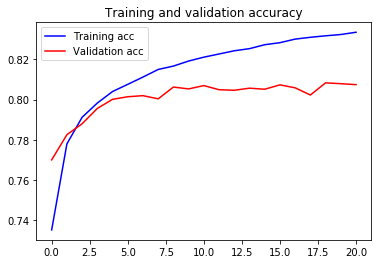

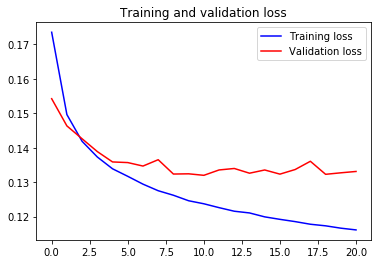

In [0]:


# Network Performances Display
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()
